In [53]:
import utils
import numpy as np
import seaborn as sn
import evaluations
from matplotlib import pyplot as plt
from itertools import combinations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

## Task 3: Optimisation Through Feature Selection

In [54]:
initial_df = utils.task1_df(isEDA=True)
_, _, df30s = utils.task4_df(isEDA=True)
df30s.head()

,TrackID,zero_cross_rate_mean,zero_cross_rate_std,rmse_mean,rmse_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,spectral_rolloff_mean,...,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,mfcc_12_std,GenreID,Genre
0,0,0.131656,0.051042,0.234452,0.069776,2569.255823,634.389892,2559.529362,417.736160,5351.909304,...,10.917519,9.436494,9.818374,7.884112,7.231014,8.026523,7.281337,6.818096,0,pop
1,1,0.099747,0.054401,0.243250,0.081652,2844.070408,953.593356,3219.148148,436.932356,6839.566975,...,13.182616,12.191261,11.272436,9.856543,10.003786,10.398938,8.929573,9.131061,0,pop
2,2,0.096015,0.060390,0.138146,0.050329,2765.648135,916.797020,3222.697319,417.432500,6873.341771,...,11.026413,14.622502,11.424296,13.402919,9.898433,9.893081,10.140719,8.330488,0,pop
3,3,0.183106,0.088115,0.212939,0.075027,3634.106564,820.191199,3134.284752,312.987674,7534.996104,...,11.044224,12.229629,12.219382,11.645808,11.426618,9.012418,10.227400,9.494127,0,pop
4,5,0.161897,0.084610,0.259807,0.096101,3671.260489,937.024680,3295.553789,333.396129,7879.044023,...,10.348630,11.043411,9.928480,8.211914,8.241311,9.336305,8.607124,7.269691,0,pop


# 1. Correlations Analysis

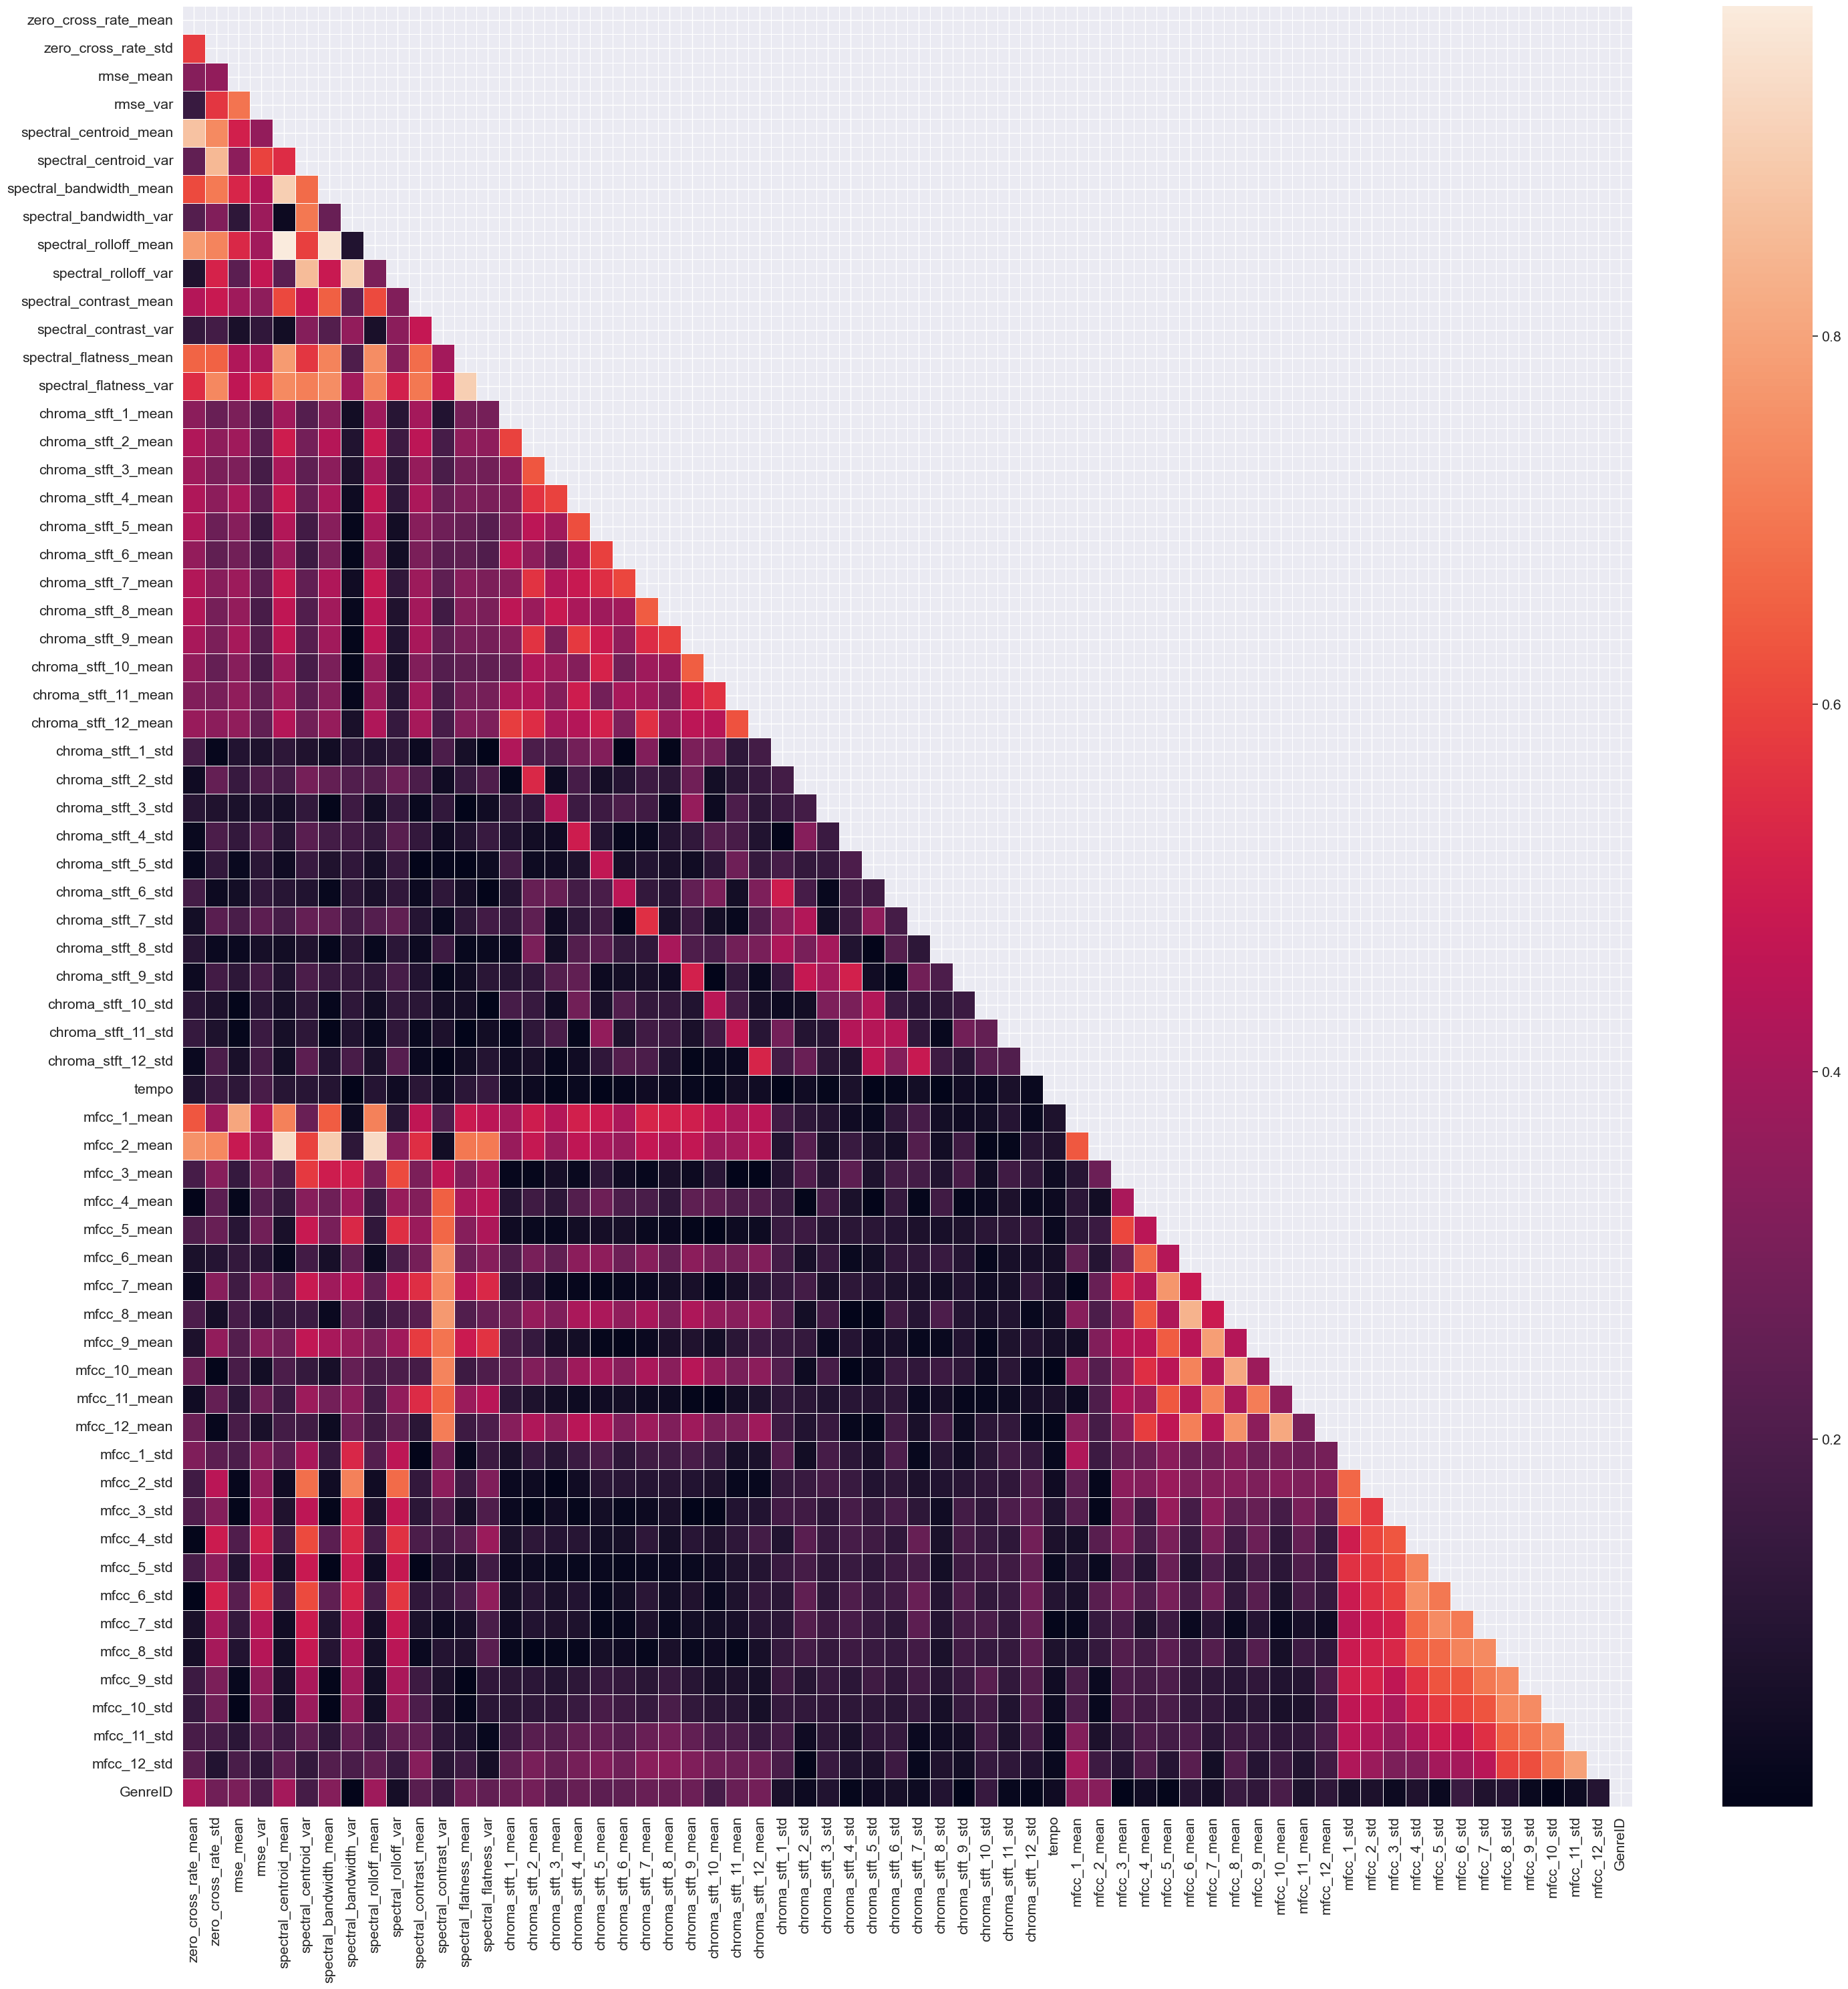

In [55]:
df_for_corr = df30s.drop(columns=['Genre', 'TrackID'])
utils.plot_corr(df_for_corr, figsize=(35,35), annot=False, keep_diag=False)

In [56]:
highest_corr = (df30s
                .drop(columns=['Genre', 'TrackID'])
                .corr().GenreID
                .drop('GenreID')
                .abs()
                .sort_values()
                .tail())
highest_corr

mfcc_2_mean               0.333709
mfcc_1_mean               0.344760
spectral_rolloff_mean     0.384887
spectral_centroid_mean    0.399847
zero_cross_rate_mean      0.413442
Name: GenreID, dtype: float64

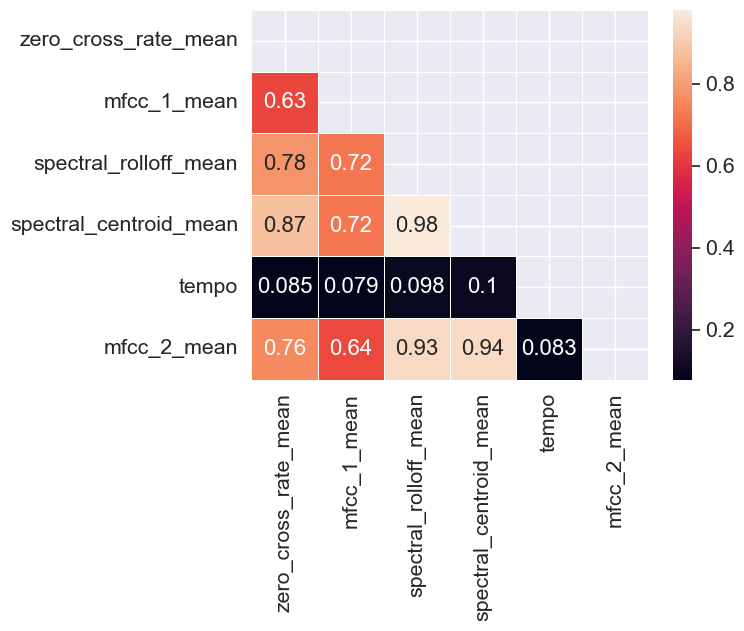

In [57]:
candidates = list(set(highest_corr.index.values).union(initial_df.drop(columns='Genre').columns.values))
utils.plot_corr(df30s[candidates], abs=True)

In [58]:
correlation_picked_features = ["zero_cross_rate_mean", "spectral_rolloff_mean", "mfcc_1_mean", "tempo" ]

### 1.1 kNN design

In [59]:
df = utils.task3_df(pickedFeatures=correlation_picked_features)
df.head()

,zero_cross_rate_mean,spectral_rolloff_mean,mfcc_1_mean,tempo,Type,GenreID
0,0.131656,5351.909304,9.675074,117.453835,Train,0
1,0.099747,6839.566975,-63.635056,107.666016,Train,0
2,0.096015,6873.341771,-119.346458,161.499023,Train,0
3,0.183106,7534.996104,-26.936581,117.453835,Train,0
4,0.161897,7879.044023,-8.531343,129.199219,Train,0


In [60]:
X_train_scaled, y_train, X_test_scaled, y_test = utils.train_val_split(df)

In [61]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, weights='distance')
knn.fit(X_train_scaled,y_train)

KNeighborsClassifier(weights='distance')

In [62]:
y_pred = knn.predict(X_test_scaled)

### 1.2 Evaluation

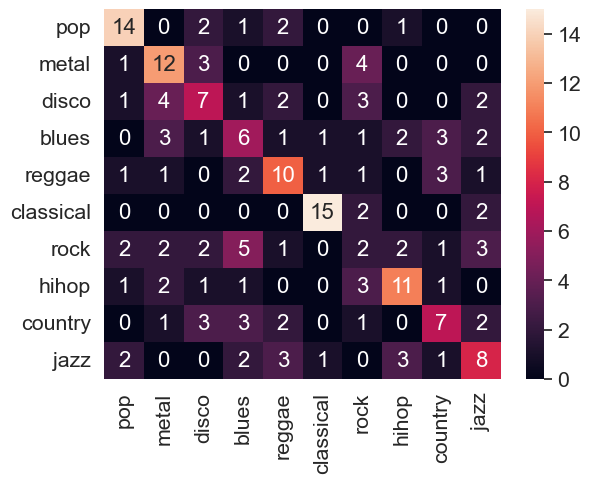

In [63]:
evaluations.conf_matrix(y_pred, y_test)

In [64]:
p = evaluations.multiclass_performance_metrics(y_pred, y_test)
print(f"Accuracy : {p.tp.sum()/len(y_pred)}\n"
      f"Macro F1 score : {p.F1Score.mean()}")
p

Accuracy : 0.46464646464646464
Macro F1 score : 0.4622483646873891


,tp,tn,fp,fn,F1Score
pop,14,170,8,6,0.666667
metal,12,165,13,8,0.533333
disco,7,166,12,13,0.358974
blues,6,163,15,14,0.292683
reggae,10,167,11,10,0.487805
classical,15,176,3,4,0.810811
rock,2,163,15,18,0.108108
hihop,11,170,8,9,0.564103
country,7,170,9,12,0.400000
jazz,8,166,12,12,0.400000


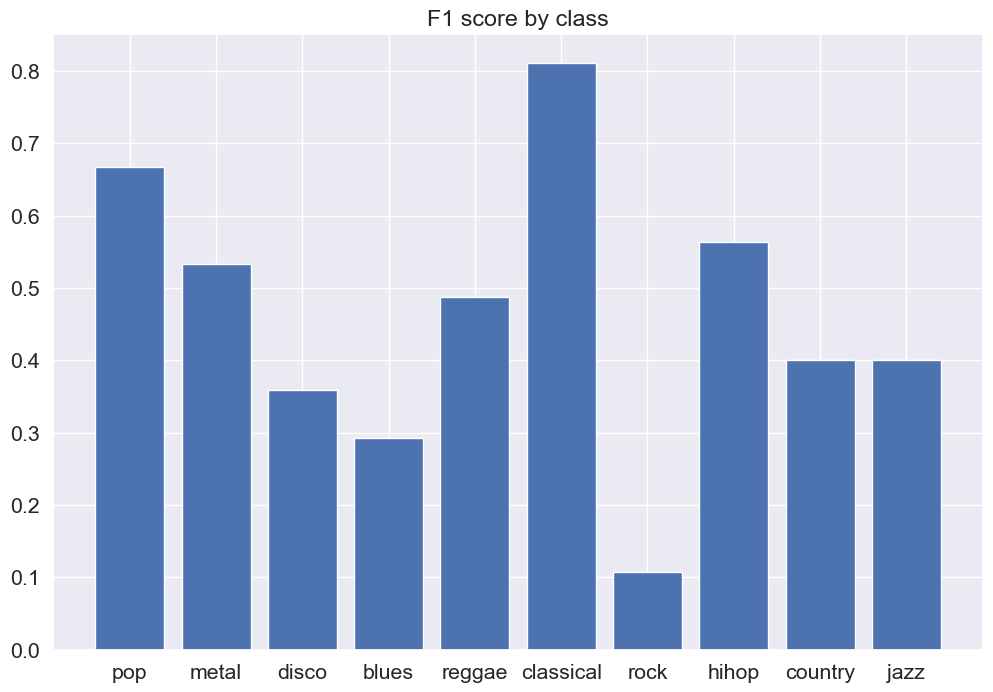

In [65]:
plt.figure(figsize=(12, 8))
plt.bar(utils.genreNames, p.F1Score)
plt.title("F1 score by class")
plt.show()

# 2. Random Forest Classifier to Determine Overall Feature Importance

### 2.1 Creating and Training Random Forest model based all features

In [66]:
_, _, df_30s_all = utils.task4_df(isEDA=False)
df_for_all = df_30s_all.drop(columns=['TrackID'])

In [67]:
feature_columns = [col for col in df_for_all.columns if col not in ['Type', 'GenreID']]

X = df_for_all[feature_columns]
y = df_for_all['GenreID']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_scaled, y)

RandomForestClassifier(random_state=42)

### 2.2 Plotting all the features importance

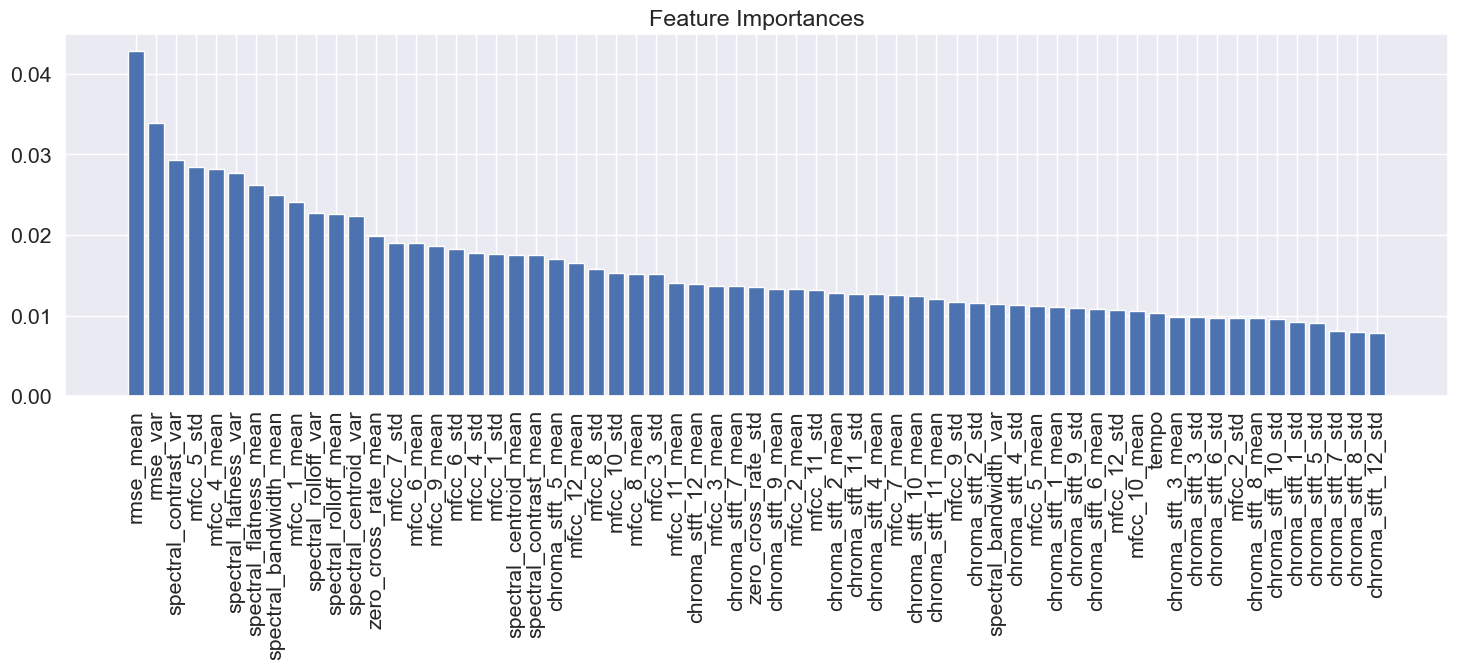

In [68]:
importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]


plt.figure(figsize=(15, 7))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), np.array(feature_columns)[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# 3. Evaluating All Possibilites

### 2.1 Training and Testing all the 236 possible Classifiers

In [69]:
feature_columns = [col for col in df_for_all.columns if col not in ['Type', 'GenreID']]

base_features = ["spectral_rolloff_mean", "mfcc_1_mean", "spectral_centroid_mean", "tempo"]
candidate_features = [f for f in feature_columns if f not in base_features]

X_train_scaled, y_train, X_test_scaled, y_test = utils.train_val_split(df_for_all)

In [70]:
results = []

for base_feats in combinations(base_features, 3):
    for additional_feature in candidate_features:
        current_features = list(base_feats) + [additional_feature]
        feature_indices = [df_for_all.columns.get_loc(f) for f in current_features]

        X_train = X_train_scaled.iloc[:, feature_indices]
        X_test = X_test_scaled.iloc[:, feature_indices]

        knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        performance_df = evaluations.multiclass_performance_metrics(y_pred, y_test, utils.genreNames)
        macro_f1 = performance_df['F1Score'].mean()  
        
        results.append((current_features, macro_f1))

results.sort(key=lambda x: x[1], reverse=True)

print("Top 12 feature combinations:")
for features, f1score in results[:12]:
    print(f"Features: {features}, F1-Score: {f1score:.4f}")

Top 12 feature combinations:
Features: ['spectral_rolloff_mean', 'spectral_centroid_mean', 'tempo', 'rmse_var'], F1-Score: 0.5212
Features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'tempo', 'rmse_var'], F1-Score: 0.5063
Features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'tempo', 'mfcc_4_std'], F1-Score: 0.5045
Features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'tempo', 'mfcc_12_mean'], F1-Score: 0.4830
Features: ['mfcc_1_mean', 'spectral_centroid_mean', 'tempo', 'rmse_var'], F1-Score: 0.4791
Features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'tempo', 'mfcc_7_std'], F1-Score: 0.4755
Features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'spectral_centroid_mean', 'rmse_var'], F1-Score: 0.4747
Features: ['mfcc_1_mean', 'spectral_centroid_mean', 'tempo', 'mfcc_6_mean'], F1-Score: 0.4702
Features: ['spectral_rolloff_mean', 'mfcc_1_mean', 'tempo', 'mfcc_1_std'], F1-Score: 0.4662
Features: ['mfcc_1_mean', 'spectral_centroid_mean', 'tempo', 'spectral_rolloff_var'], F1-Score: 0.4642
Features: ['spe

### 2.2 Result Visualisation: F1-score Heatmap

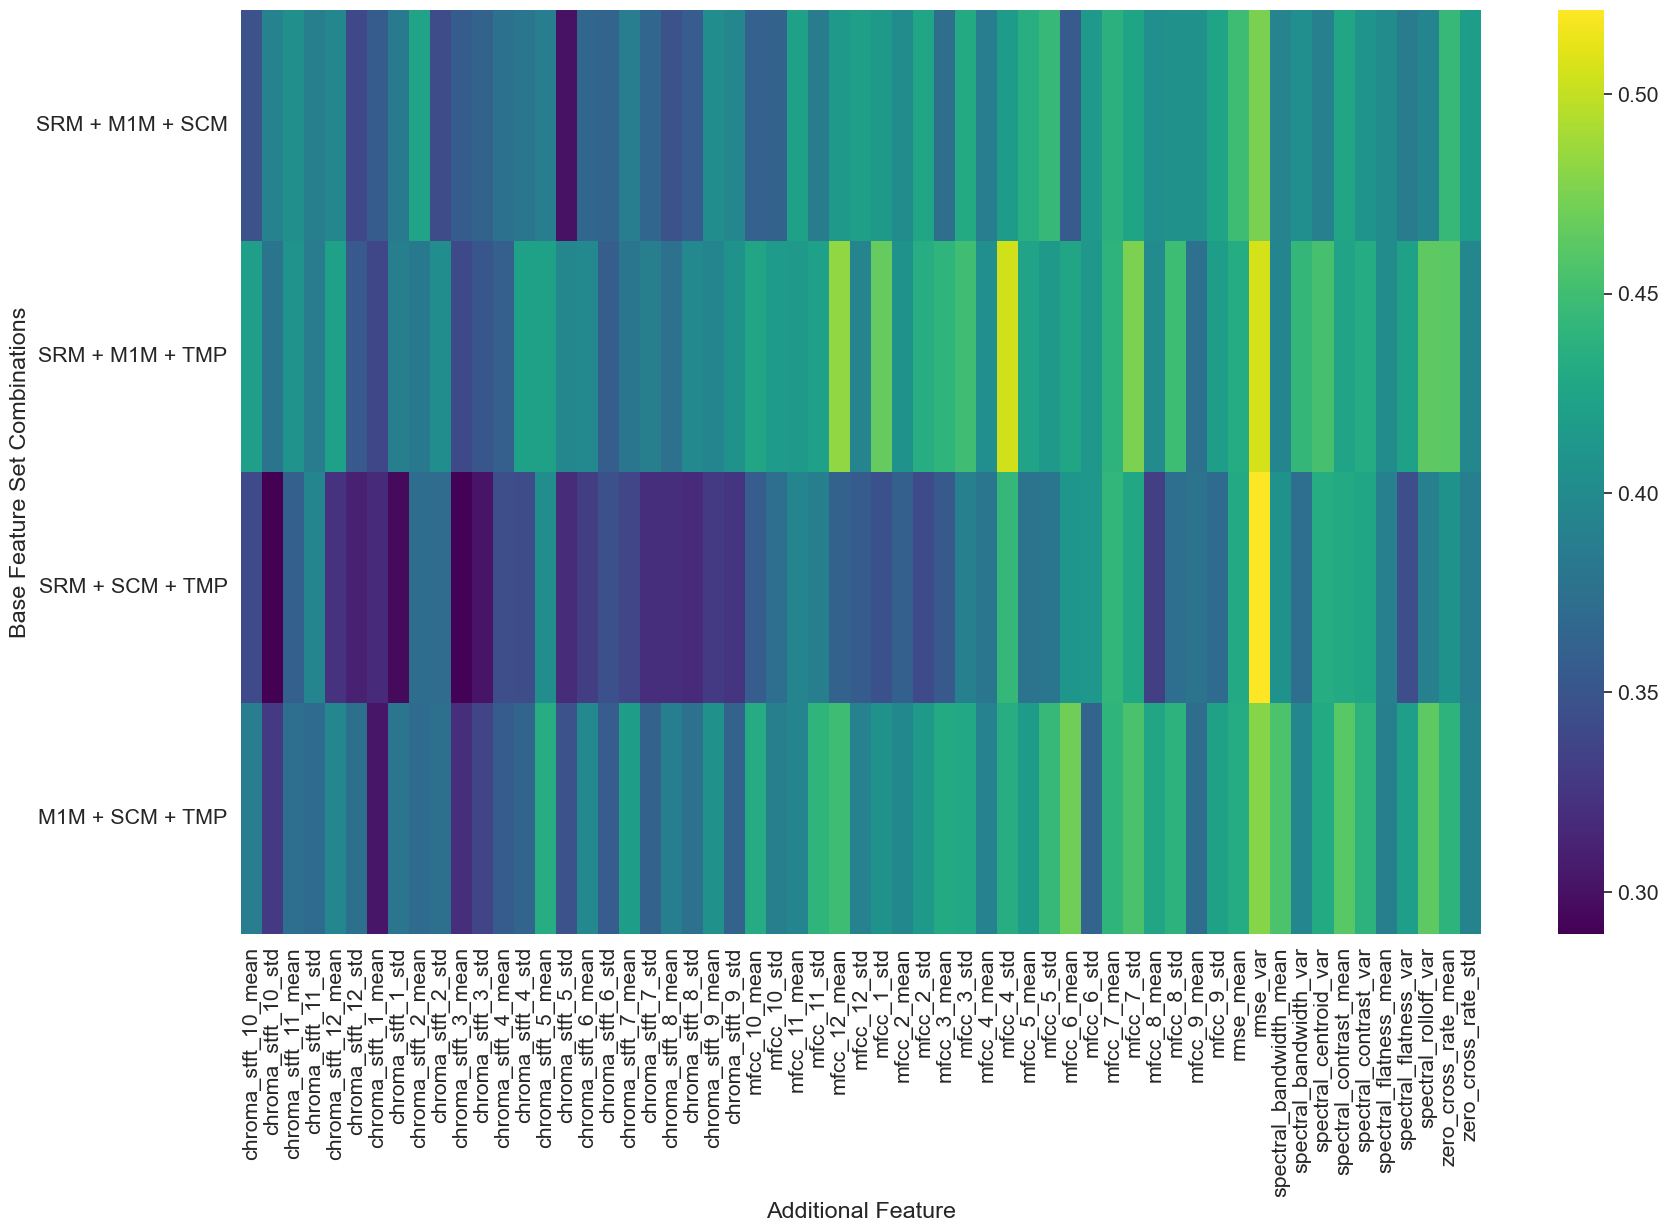

In [71]:
feature_abbreviations = {
    "spectral_rolloff_mean": "SRM",
    "mfcc_1_mean": "M1M",
    "spectral_centroid_mean": "SCM",
    "tempo": "TMP"
}

three_feature_combinations = list(combinations(base_features, 3))
base_feature_sets = [' + '.join(feature_abbreviations[feat] for feat in combo) for combo in three_feature_combinations]

unique_additional_features = sorted(set(f[0][-1] for f in results))

heatmap_data = np.zeros((len(three_feature_combinations), len(unique_additional_features)))

additional_feature_index = {feat: idx for idx, feat in enumerate(unique_additional_features)}
base_feature_set_index = {feat: idx for idx, feat in enumerate(base_feature_sets)}

for features, f1 in results: 
    base_features_selected = ' + '.join(feature_abbreviations[feat] for feat in features[:-1])
    additional_feature = features[-1]
    base_index = base_feature_set_index[base_features_selected]
    feature_index = additional_feature_index[additional_feature]
    heatmap_data[base_index, feature_index] = f1


plt.figure(figsize=(20, 12))
ax = sn.heatmap(heatmap_data, fmt=".2f", xticklabels=unique_additional_features, 
                 yticklabels=[k for k in base_feature_set_index.keys()], cmap='viridis', annot=False)
plt.xlabel('Additional Feature')
plt.ylabel('Base Feature Set Combinations')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()


### 2.3 How is the best combination actually performing?

In [72]:
best_performing_features = ["rmse_var", "spectral_rolloff_mean", "spectral_centroid_mean", "tempo" ]

In [73]:
df = utils.task3_df(pickedFeatures=best_performing_features)
X_train_scaled, y_train, X_test_scaled, y_test = utils.train_val_split(df)
knn = KNeighborsClassifier(n_neighbors = 5, weights='distance')
knn.fit(X_train_scaled,y_train)
y_pred = knn.predict(X_test_scaled)

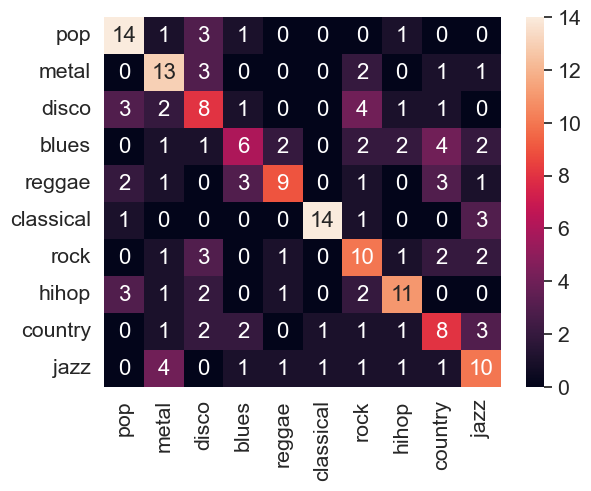

In [74]:
evaluations.conf_matrix(y_pred, y_test)

In [75]:
p = evaluations.multiclass_performance_metrics(y_pred, y_test)
print(f"Accuracy : {p.tp.sum()/len(y_pred)}\n"
      f"Macro F1 score : {p.F1Score.mean()}")
p

Accuracy : 0.5202020202020202
Macro F1 score : 0.5212185600017698


,tp,tn,fp,fn,F1Score
pop,14,169,9,6,0.651163
metal,13,166,12,7,0.577778
disco,8,164,14,12,0.380952
blues,6,170,8,14,0.352941
reggae,9,173,5,11,0.529412
classical,14,177,2,5,0.800000
rock,10,164,14,10,0.454545
hihop,11,171,7,9,0.578947
country,8,167,12,11,0.410256
jazz,10,166,12,10,0.476190
